### 코더의 소회 : 
날씨 : 오늘의 학습 < >했습니다. [☀️⛅☁️🌧️🌩️⛈️]
- 배운점 : 
- 아쉬운점 :  
- 느낀점 :

(참고 : https://github.com/Annyong2/AIFFEL_quest_rs/tree/master/GoingDeeper/Gdr06)

### 전체 코드 실행 플로우 (목차):

**STEP 1. 불러오기 : 라이브러리 & 데이터**  

**STEP 2. 데이터 정제**  

**STEP 3. 데이터 토큰화**  

**STEP 4. Augmentation**  

**STEP 5. 데이터 벡터화**  

**STEP 6. 훈련하기**  


---

# STEP 1. 불러오기 : 라이브러리 & 데이터
---

#### 라이브러리

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm  # 폰트 설정
from sklearn.model_selection import train_test_split
import os
import re
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

import konlpy              
from konlpy.tag import Mecab
import nltk
from nltk.corpus import wordnet
import gensim
import random

print(np.__version__)
print(pd.__version__)
print(tf.__version__)
print(nltk.__version__)
print(gensim.__version__)

1.21.4
1.3.3
2.6.0
3.6.5
3.8.3


In [2]:
# pip install --upgrade gensim==3.8.3

# 서승한 그루님께 감사 (ref : https://iambeginnerdeveloper.tistory.com/41)

#### 한글설정

In [3]:
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina'")
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("완료!")

완료!


#### 데이터불러오기

In [4]:
data_dir = os.getenv('HOME')+'/aiffel/transformer_chatbot/data'
data_path = data_dir + '/ChatbotData.csv'

df_csv = pd.read_csv(data_path)
df = df_csv.copy()

df.sample(10)

,Q,A,label
3231,연일 최고 몸무게 갱신하네.,이제 내려올 때가 됐어요.,0
8204,지쳐서 헤어진 남자랑은 재회가능성,달라지는 게 없다면 만나지 않는 게 더 나을 수도 있어요.,1
6849,아이디 생각 안나,회원정보 찾기를 해보세요.,1
774,남편이 집안일 안 해,잘 분담해보세요.,0
9025,교양 듣는데 심남 있음. 썸 타고 싶다.,호감을 어느 정도 표현해보는 것도 좋을 것 같아요.,2
2021,백조됐어,저랑 놀아요.,0
8629,헤어진지 2달 다되어가는데,머리에서 지우세요.,1
7659,이제 겨우 일주일 됐네,일주일이나 지난 거예요.,1
10272,썸남 꿈 꿨어.,그분 생각을 많이 했나 봐요. 곧 좋은 소식이 들리려고 하는 것 아닐까요?,2
8651,헤어진지 42일째.,하루 하루를 세는 건 자신을 더 힘들게 만들 뿐이에요.,1


#### 데이터 보기

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


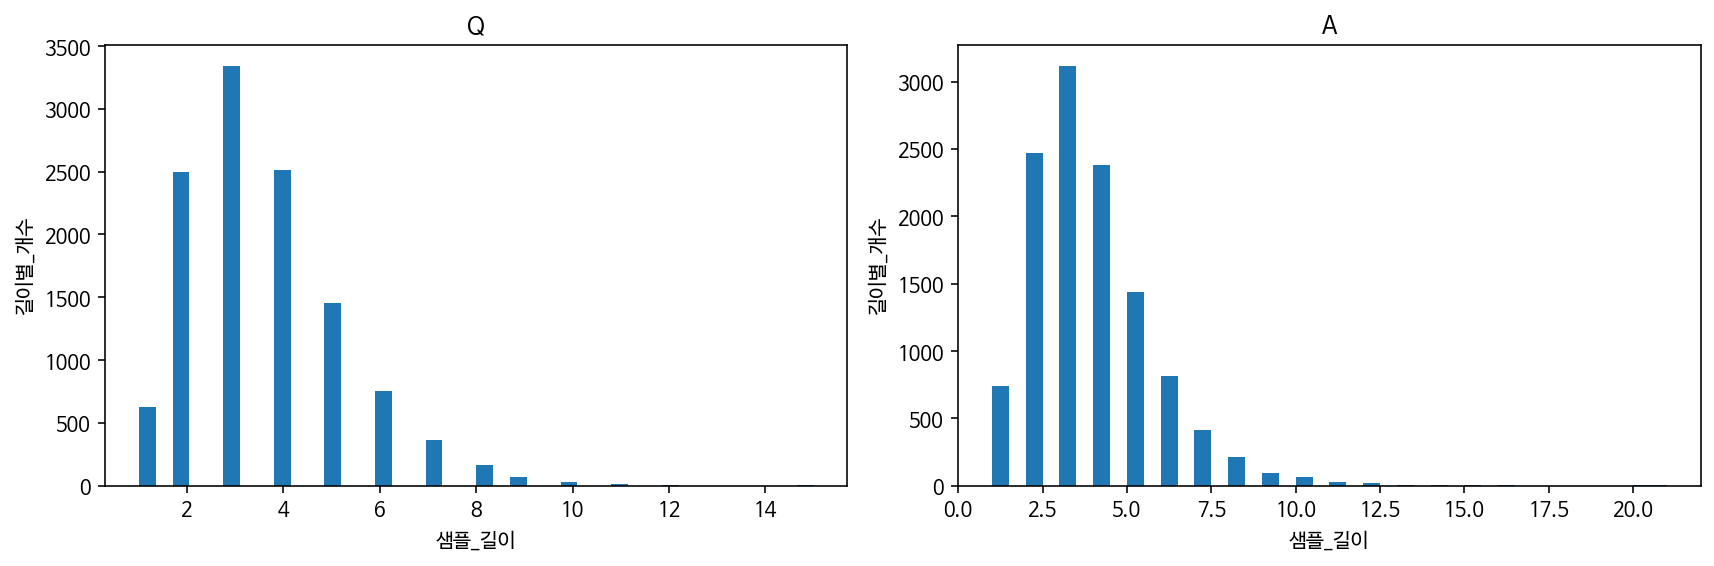

 질문(min, Max, mean) : (1 , 15 , 3.59)
 답변(min, Max, mean) : (1 , 21 , 3.69)


In [6]:
Q_len = [len(s.split()) for s in df['Q']]
A_len = [len(s.split()) for s in df['A']]

# Subplots 생성 (1행 2열로 배치)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# 첫 번째 그래프 (Q_len)
ax1.set_title('Q')
ax1.hist(Q_len, bins=40)
ax1.set_xlabel('샘플_길이')
ax1.set_ylabel('길이별_개수')

# 두 번째 그래프 (A_len)
ax2.set_title('A')
ax2.hist(A_len, bins=40)
ax2.set_xlabel('샘플_길이')
ax2.set_ylabel('길이별_개수')

# 레이아웃 조정 후 출력
plt.tight_layout()
plt.show()

print(f" 질문(min, Max, mean) : ({np.min(Q_len)} , {np.max(Q_len)} , {round(np.mean(Q_len),2)})")
print(f" 답변(min, Max, mean) : ({np.min(A_len)} , {np.max(A_len)} , {round(np.mean(A_len),2)})")

#### 데이터 변수`questions` 와 `answers`에 넣기

In [7]:
questions = df['Q'].tolist()
answers  =  df['A'].tolist()

print(f"len(questions) : {len(questions)} \nlen(answers)   : {len(answers)} \n\n type(questions) >>> {type(questions)} \n type(answers)   >>> {type(answers)} \n\n questions[5167]  >>> {questions[5167]} \n answers[5167]    >>> {answers[5167]}")

len(questions) : 11823 
len(answers)   : 11823 

 type(questions) >>> <class 'list'> 
 type(answers)   >>> <class 'list'> 

 questions[5167]  >>> 홈쇼핑에서 자꾸 사게되네 
 answers[5167]    >>> 지름신이 강림했나봅니다.


👁️👁️Data Review : 

⚠️**오류기록 :** 

👁️👁️**코멘트 :** 

# STEP 2.데이터 정제
---

In [8]:
def preprocess_sentence(sentence):
    # 1. 소문자 변환
    sentence = sentence.lower()

    # 2. 알파벳, 문장부호, 한글 외 제거
    sentence = re.sub(r'\d', '', sentence)

    return sentence

# STEP 3. 데이터 토큰화
--- 


In [9]:
def build_corpus(src, tgt, sen_len_limit):  # 소스 문장 데이터와 타겟 문장 데이터를 입력으로 받습니다.
    
    src_corpus = []
    tgt_corpus = []
    mecab = Mecab()
    
    # 입력 데이터 길이 확인
    assert len(src) == len(tgt), "소스와 타겟 데이터 길이가 일치하지 않습니다."
    
    # 소스와 타겟 데이터 처리
    for i in range(len(src)):
        # 정제 후 토큰화 (리스트를 문자열로 변환)
        src_corpus.append(" ".join(mecab.morphs(preprocess_sentence(src[i]))))  # 소스 문장 토큰화
        tgt_corpus.append(" ".join(mecab.morphs(preprocess_sentence(tgt[i]))))  # 타겟 문장 토큰화
    
    # 소스와 타겟 데이터를 튜플로 묶고, 중복 제거 (튜플은 set에 넣을 수 있음)
    dataset = list(zip(src_corpus, tgt_corpus))
    cleaned_corpus = list(set(dataset))  # 문자열로 변환된 데이터를 그대로 set에 넣어 중복 제거
    corpus_1, corpus_2 = zip(*cleaned_corpus)
    
    # print(f"type(corpus_1) : {type(corpus_1)}")
    print(f"<corpus별 모든 문장 길이 (제거전)>")
    print(f"len(corpus_1) : {len(corpus_1)}")
    print(f"len(corpus_2) : {len(corpus_2)}")
    
    s_corpus = []
    t_corpus = []
    
   # 길이 제한을 적용하여 토큰의 개수가 일정 길이 이상인 문장은 제외
    for idx in tqdm(range(len(corpus_1))):
        if len(corpus_1[idx]) <= sen_len_limit and len(corpus_2[idx]) <= sen_len_limit:  
            s_corpus.append(corpus_1[idx])
            t_corpus.append(corpus_2[idx])
            # print(f"len(s_corpus) [{idx}] : {len(corpus_1[idx])}")
            # print(f"len(t_corpus) [{idx}] : {len(corpus_2[idx])}")
            
    print(f"len(que_corpus) : {len(s_corpus)} ,(제거: {len(corpus_1)-len(s_corpus)})")
    print(f"len(ans_corpus) : {len(t_corpus)} ,(제거: {len(corpus_2)-len(t_corpus)})")
    
    return s_corpus, t_corpus

In [10]:
que_corpus =[]
ans_corpus =[]

que_corpus, ans_corpus = build_corpus(questions, answers, 25)

<corpus별 모든 문장 길이 (제거전)>
len(corpus_1) : 11748
len(corpus_2) : 11748


  0%|          | 0/11748 [00:00<?, ?it/s]

len(que_corpus) : 8510 ,(제거: 3238)
len(ans_corpus) : 8510 ,(제거: 3238)


In [11]:
print(que_corpus[:3])

['축제 날 은 즐겨야 지', '안경 벗 으면 나 으려나', '요즘 너무 고민 이 네']


In [12]:
print(ans_corpus[:3])

['즐길 수 있 을 때 즐기 세요 .', '다른 안경 써 보 세요 .', '무슨 고민 인지 말 해 주 세요 .']


# STEP 4. Augmentation
---

In [13]:
def download_dataset(zip_path, save_path, zipfile):
    # 데이터셋 폴더 생성
    if not os.path.exists(save_path):
        os.makedirs(save_path)    
    
    # 데이터셋 다운로드
    path_to_zip = tf.keras.utils.get_file(
        zipfile,
        origin=zip_path,
        extract=True,
        cache_dir=save_path)

    os.system("unzip "+zipfile+" -d "+save_path)
    
    return zip

In [14]:
zip_path = 'https://drive.google.com/open?id=0B0ZXk88koS2KbDhXdWg1Q2RydlU'
save_path = data_dir
zipfile = 'ko'

download_dataset(zip_path, save_path, zipfile)

unzip:  cannot find or open ko, ko.zip or ko.ZIP.


zip

In [15]:
path = data_dir
os.listdir(path)

['ko.bin',
 'word2vec_ko.model.wv.vectors.npy',
 'datasets',
 'ChatbotData.csv',
 'word2vec_ko.model',
 'ChatbotData .csv',
 'word2vec_ko.model.trainables.syn1neg.npy']

In [16]:
'''ko_path = path + '/datasets/ko.bin'
with open(ko_path, "r") as f:
    raw_ko = f.read().splitlines()
print("Data Size:", len(raw_ko))
print("Example:")

for sen_ko in raw_ko[0:100][::20]: print(">>", sen_ko)    '''

'ko_path = path + \'/datasets/ko.bin\'\nwith open(ko_path, "r") as f:\n    raw_ko = f.read().splitlines()\nprint("Data Size:", len(raw_ko))\nprint("Example:")\n\nfor sen_ko in raw_ko[0:100][::20]: print(">>", sen_ko)    '

👁️👁️Data Review : 

In [17]:
from gensim.models import KeyedVectors

ko_path = path + '/datasets/ko.bin'
wv = gensim.models.Word2Vec.load(ko_path)

wv.most_similar("학교")

/tmp/ipykernel_234/2104412595.py:6: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  wv.most_similar("학교")


[('학교의', 0.7560996413230896),
 ('강습소', 0.7425637245178223),
 ('중고등학교', 0.7386142015457153),
 ('전문학교', 0.7356827855110168),
 ('사립학교', 0.7347193956375122),
 ('소학교', 0.7305554747581482),
 ('여학교', 0.7091007232666016),
 ('사범학교', 0.6901223659515381),
 ('대학', 0.6897724866867065),
 ('학원', 0.6869212985038757)]

In [18]:
# Lexical Substitution
def lexical_sub(sample_sentence,wv):  
    sample_tokens = sample_sentence.split()
    selected_tok = random.choice(sample_tokens)

    result = ""
    
    for tok in sample_tokens:
        if tok == selected_tok:
            try:
                # vocabulary에 있으면 교체, 없으면 예외 처리
                substitute_word = wv.most_similar(tok)[0][0]
                result += substitute_word + " "
            except KeyError:
                # 단어가 vocabulary에 없으면 원래 단어를 사용
                result += tok + " "
        else:
            result += tok + " "

    return result.strip()


# 확인
sample_sentences = ['시 땡 !', '지망 학교 떨어졌 어', '박일 놀 러 가 고 싶 다']
example_corpus = []

for sample_sen in tqdm(sample_sentences):
    example_sen = lexical_sub(sample_sen, wv)
    if example_sen is not None: 
        example_corpus.append(example_sen)
    else :
        # Augmentation이 없더라도 원본 문장을 포함시킵니다
        example_corpus.append(sample_sen)

print(example_corpus)

  0%|          | 0/3 [00:00<?, ?it/s]

['시가 땡 !', '중퇴 학교 떨어졌 어', '박일 놀 ㄹ래 가 고 싶 다']


/tmp/ipykernel_234/3588119805.py:12: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  substitute_word = wv.most_similar(tok)[0][0]


In [19]:
def augment_corpus_with_lexical_substitution(sample_sentences, wordvector):
    example_corpus = []

    for sample_sen in tqdm(sample_sentences):
        example_sen = lexical_sub(sample_sen, wordvector)
        if example_sen is not None: 
            example_corpus.append(example_sen)
        else:
            # Augmentation이 없더라도 원본 문장을 포함시킵니다
            example_corpus.append(sample_sen)

    return example_corpus

In [20]:
aug_que_corpus = []
aug_ans_corpus = []

aug_que_corpus.append(augment_corpus_with_lexical_substitution(que_corpus, wv))
aug_ans_corpus.append(augment_corpus_with_lexical_substitution(ans_corpus, wv))

  0%|          | 0/8510 [00:00<?, ?it/s]

/tmp/ipykernel_234/3588119805.py:12: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  substitute_word = wv.most_similar(tok)[0][0]


  0%|          | 0/8510 [00:00<?, ?it/s]

# STEP 5. 데이터 벡터화
---

👁️👁️Data Review : 

# STEP 6. 훈련하기
---

👁️👁️Data Review : 

In [ ]:
'''
src_corpus = []
tgt_corpus = []
mecab = Mecab()

# 입력 데이터 길이 확인
assert len(src) == len(tgt), "소스와 타겟 데이터 길이가 일치하지 않습니다."

# 소스와 타겟 데이터 처리
for i in range(len(src)):
    # 정제 후 토큰화
    src_corpus.append(mecab.morphs(preprocess_sentence(src[i])))  # 소스 문장 토큰화
    tgt_corpus.append(mecab.morphs(preprocess_sentence(tgt[i])))  # 타겟 문장 토큰화

# 중복 제거 
# (병렬로 묶어서 중복쌍 유지. set을 사용하여 중복 제거 후 리스트로 변환하고, 다시 각각 corpus로 나눔)    
dataset = list(zip(src_corpus, tgt_corpus))
cleaned_corpus = list(set(dataset))
corpus_1, corpus_2 = zip(*cleaned_corpus)
print(f"len(corpus_1) : {len(corpus_1)}")
print(f"len(corpus_2) : {len(corpus_2)}")

 길이 제한을 적용하여 토큰의 개수가 일정 길이 이상인 문장은 제외
for idx in tqdm(range(len(cleaned_corpus))):
    if len(corpus_1[idx]) <= 8 and len(corpus_2[idx]) <= 8:  
        src_corpus.append(corpus_1[idx])
        tgt_corpus.append(corpus_2[idx])
'''